# Podstawy gymnasium - sprawozdanie
#### Szymon Frączek, Piotr Gąsiorek
---

### Wstęp
Uczenie ze wzmocnieniem (Reinforcement Learning, RL) jest obszarem sztucznej inteligencji skoncentrowanym na wyuczeniu agenta podejmowania decyzji przez interakcje ze środowiskiem. W środowisku MountainCar agent steruje samochodem, którego zadaniem jest dotarcie na szczyt górskiego wzniesienia. Samochód ma ograniczoną moc silnika, co sprawia, że nie jest w stanie pokonać wzniesienia bez odpowiedniej strategii. W ramach projektu zrealizowaliśmy algorytm uczenia ze wzmocnieniem - Q-learning - w środowisku symulacyjnym MountainCar z wykorzystaniem biblioteki gymnasium. W pracy przedstawimy proces projektowania agenta, analizę jego zdolności uczenia się oraz eksperymenty mające na celu optymalizację procesu uczenia. Eksperymenty zostały przeprowadzone na bazie 5000 epizodów, a ich wyniki zwizualizowaaliśmy na krzywej uczenia.

### Instalacja środowiska
Instalujemy wymagane biblioteki jak gymnasium, numpy, matplotlib.

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

### Implementacja algorytmu
Agent został zaimplementowany w języku Python. Do reprezentacji stanu środowiska wykorzystaliśmy dyskretyzację przestrzeni obserwacji, dzieląc ją na 20 segmentów zarówno dla pozycji, jak i prędkości. Takie podejście umożliwiło zastosowanie tablicy Q do przechowywania wartości funkcji akcji.

Wybraliśmy algorytm Q-learning, będący bezmodelową metodą uczenia ze wzmocnieniem, pozwalającą agentowi ocenić wartość każdej z możliwych akcji bez konieczności posiadania modelu środowiska. Użyto zmiennego współczynnika uczenia i współczynnika, który pomaga określić, jak bardzo cenić przyszłe nagrody.

## Analiza Algorytmu Q-learning w Środowisku MountainCar

### Inicjalizacja Środowiska

```python
env = gym.make('MountainCar-v0', render_mode='human' if render else None)
```
Algorytm rozpoczyna od stworzenia instancji środowiska gry MountainCar-v0 za pomocą biblioteki Gym. Opcjonalna wizualizacja środowiska jest dostępna, gdy parametr render jest ustawiony na True.

### Dyskretyzacja Przestrzeni Stanów

```python
pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)
vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)
```
Środowisko MountainCar ma ciągłą przestrzeń stanów, więc kod dyskretyzuje przestrzeń pozycji i prędkości, dzieląc je na 20 równych segmentów. Pozwala to na zastosowanie tablicy Q dla reprezentacji funkcji wartości.

### Inicjalizacja Tablicy Q

```python
if(is_training):
    q = np.zeros((len(pos_space), len(vel_space), env.action_space.n))
else:
    f = open('mountain_car.pkl', 'rb')
    q = pickle.load(f)
    f.close()
```

Jeśli jest to faza treningu, tworzona jest tablica Q z zerami dla każdej kombinacji segmentów pozycji i prędkości oraz dla każdej akcji. Dla fazy testowania tablica Q jest wczytywana z pliku.

### Parametry Algorytmu

```python
learning_rate_a = 0.9
discount_factor_g = 0.9
epsilon = 1
epsilon_decay_rate = 2/episodes
rng = np.random.default_rng()
```

Ustalenie współczynnika uczenia (learning_rate_a), współczynnika dyskontującego (discount_factor_g), początkowej wartości eksploracji (epsilon) i szybkości jej spadku (epsilon_decay_rate).

### Przebieg Epizodu

```python
for i in range(episodes):
    ...
```

Dla każdego epizodu, środowisko jest resetowane i agent otrzymuje początkowy stan. Następnie agent wykonuje akcje aż do osiągnięcia celu lub przekroczenia limitu czasu/nagród.

### Wybór Akcji

```python
if(rng.random() < epsilon):
    action = env.action_space.sample()
else:
    action = np.argmax(q[pos, vel])
```

Agent wybiera akcję zgodnie z strategią ε-greedy. W przypadku eksploracji, losowana jest akcja z przestrzeni akcji środowiska. W przypadku eksploatacji, wybierana jest akcja o najwyższej wartości funkcji Q.

### Aktualizacja Tablicy Q

```python
q[state_p, state_v, action] = q[state_p, state_v, action] + learning_rate_a * (
                    reward + discount_factor_g*np.max(q[new_state_p, new_state_v,:]) - q[state_p, state_v, action]
                )
```

Tablica Q jest aktualizowana zgodnie z równaniem Bellmana. Nowa wartość funkcji Q jest obliczana na podstawie nagrody, współczynnika uczenia, współczynnika dyskontującego i wartości funkcji Q dla następnego stanu.

In [ ]:
def run(episodes, is_training=True, render=False):

    env = gym.make('MountainCar-v0', render_mode='human' if render else None)

    pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)
    vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)

    if(is_training):
        q = np.zeros((len(pos_space), len(vel_space), env.action_space.n))
    else:
        f = open('mountain_car.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    learning_rate_a = 0.9
    discount_factor_g = 0.9

    epsilon = 1
    epsilon_decay_rate = 2/episodes
    rng = np.random.default_rng()

    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        state = env.reset()[0]
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)

        terminated = False

        rewards=0

        while(not terminated and rewards>-1000):

            if is_training and rng.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q[state_p, state_v, :])

            new_state,reward,terminated,_,_ = env.step(action)
            new_state_p = np.digitize(new_state[0], pos_space)
            new_state_v = np.digitize(new_state[1], vel_space)

            if is_training:
                q[state_p, state_v, action] = q[state_p, state_v, action] + learning_rate_a * (
                    reward + discount_factor_g*np.max(q[new_state_p, new_state_v,:]) - q[state_p, state_v, action]
                )

            state = new_state
            state_p = new_state_p
            state_v = new_state_v

            rewards+=reward

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        rewards_per_episode[i] = rewards

        print(f'Episode {i+1}/{episodes}, rewards: {rewards}')

    env.close()

    if is_training:
        f = open('mountain_car.pkl','wb')
        pickle.dump(q, f)
        f.close()

    mean_rewards = np.zeros(episodes)
    for t in range(episodes):
        mean_rewards[t] = np.mean(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(mean_rewards)
    plt.savefig(f'mountain_car.png')

### Trening agenta
Eksperymenty obejmowały trening agenta przez 5000 epizodów z zastosowaniem początkowo wysokiego poziomu eksploracji (ε = 1), który był stopniowo zmniejszany. W celu oceny efektywności uczenia na bieżąco rejestrujemy sumę nagród w każdym epizodzie.

In [ ]:
run(5000, is_training=True, render=False)

Średnie nagrody w początkowych epizodach oscylowały w okolicach -1000, co sugeruje brak osiągnięcia celu przez agenta. W miarę postępu treningu wartości te ulegały znacznemu poprawieniu, osiągając poziom -200, co oznacza znaczące zrozumienie zadania przez agenta.

Na krzywej uczenia widoczna jest początkowa niska efektywność agenta, która stopniowo wzrasta. Skok wartości nagród około 2000 epizodu świadczy o możliwym odkryciu przez agenta efektywnej strategii. W dalszej fazie uczenia obserwujemy stabilizację wyników, co wskazuje na osiągnięcie przez agenta optymalnej strategii.

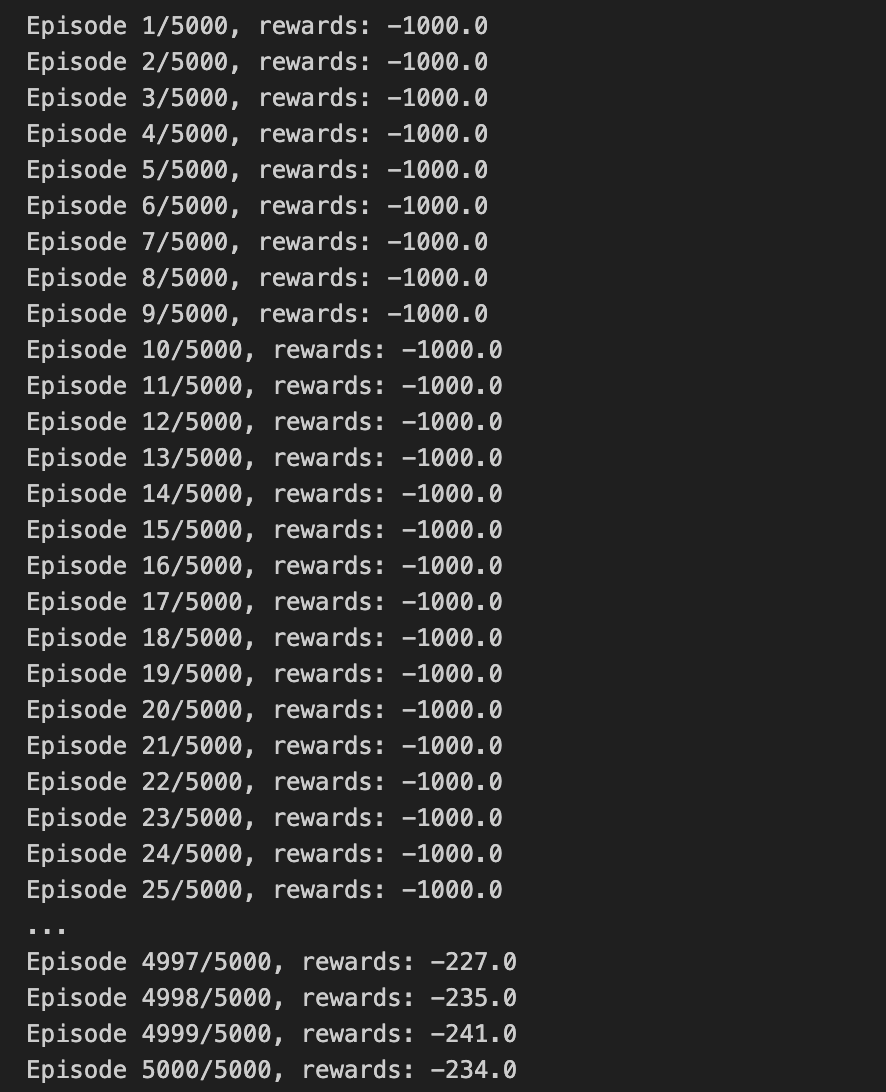
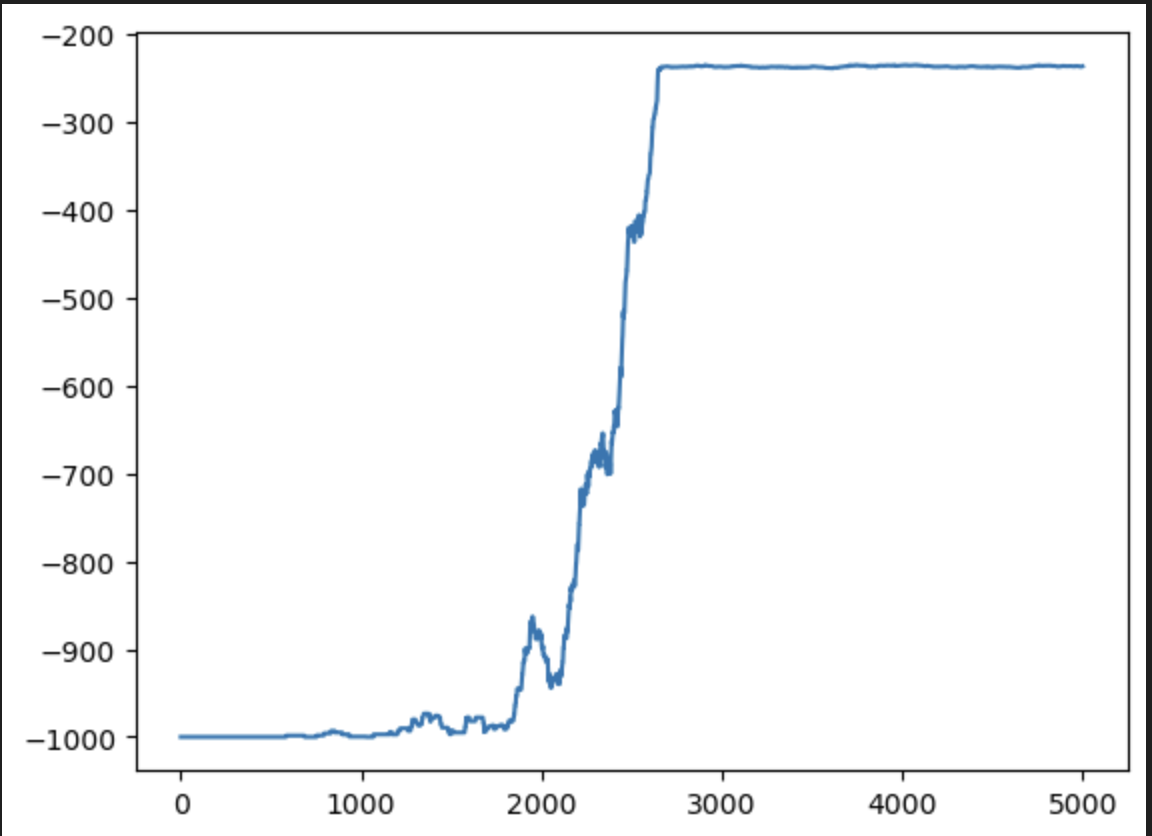

### Testowanie agenta
W celu oceny efektywności agenta przeprowadzono testowanie na 100 epizodach. Średnia suma nagród w testowaniu wyniosła -177, co pokazuje, ze agent osiągnął cel. Wizualizacja przebiegu testowania potwierdza zdolność agenta do dotarcia na szczyt wzgórza.

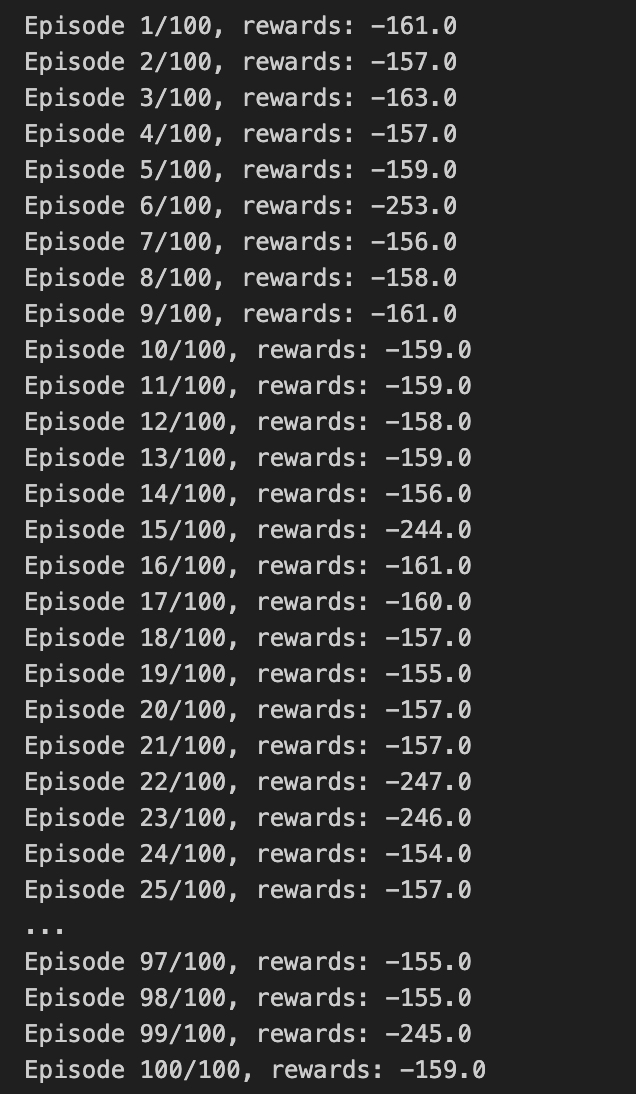
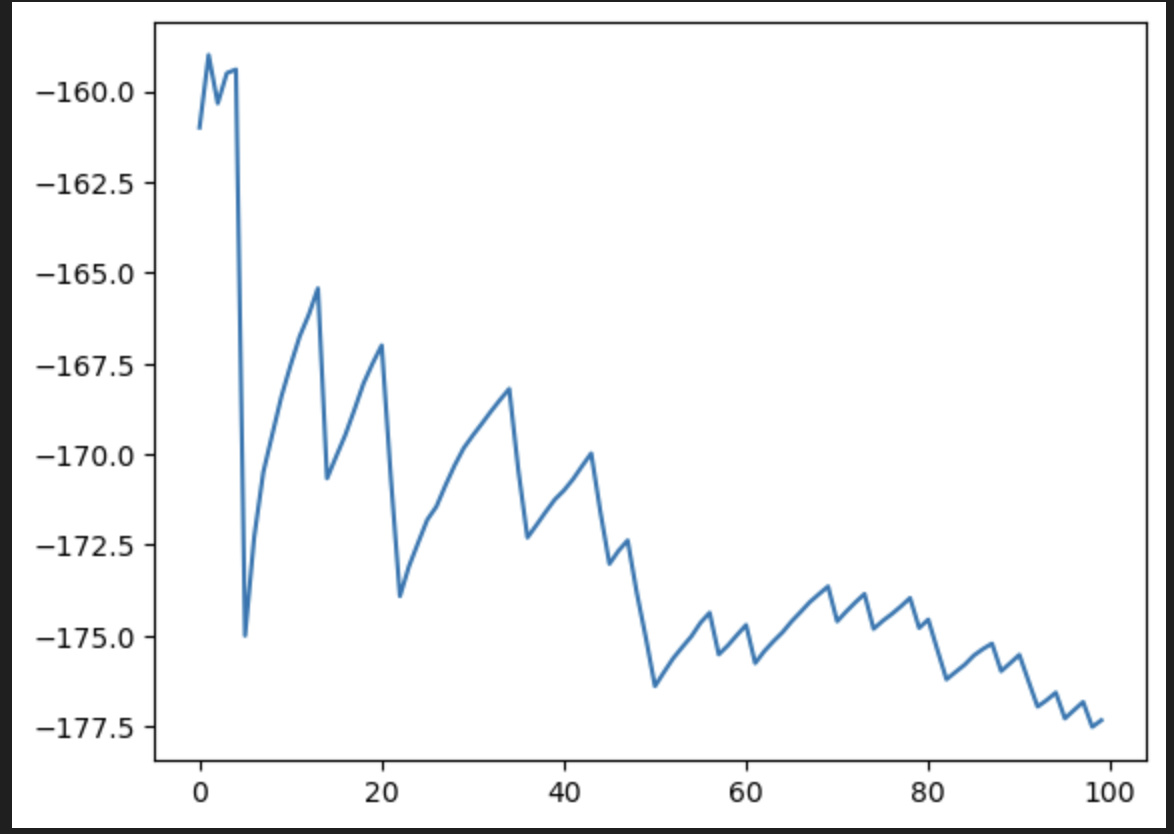

### Wnioski
Implementacja algorytmu Q-learning w środowisku MountainCar pozwoliła na skuteczne nauczenie agenta zadania. Uzyskane wyniki potwierdzają możliwość zastosowania uczenia ze wzmocnieniem do problemów sterowania. Proces uczenia wymagał około 2000 epizodów, poniewaz, agent potrzebował czasu na zrozumienie złożoności środowiska.

# Humanoid - przesrzeń ciągła

Kolejnym środowiskiem, które testowaliśmy był Humanoid. Jest to środowisko z przestrzenią ciągłą, w którym agent steruje humanoidem, próbującym nauczyć się chodzenia. W przeciwieństwie do MountainCar, Humanoid jest bardziej złożonym środowiskiem, co sprawia, że uczenie agenta jest bardziej wymagające.

### Instalacja środowiska
Instalujemy wymagane biblioteki jak gymnasium, numpy, matplotlib, stable_baselines3.

In [ ]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import SAC, TD3, A2C
import matplotlib.pyplot as plt
import os

### Zdefiniowanie folderu do zapisywania wyników


In [ ]:
models_dir = 'models'
logs_dir = 'logs'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)

### Metoda uczenia
W ramach naszego projektu przeprowadziliśmy eksperymenty mające na celu porównanie wydajności trzech różnych algorytmów uczenia ze wzmocnieniem: A2C (Advantage Actor-Critic), SAC (Soft Actor-Critic) oraz TD3 (Twin Delayed DDPG). Dla każdego z algorytmów, obserwowaliśmy dwie kluczowe metryki w czasie: średnią nagrodę na epizod (rollout/ep_rew_mean) oraz średnią długość epizodu (rollout/ep_len_mean), zgodnie z poniższymi wykresami.

In [ ]:
def train(env, sb3_algo, max_iters=4, model=None, curr_name=None):
    if model is None:
        match sb3_algo:
            case 'SAC':
                model = SAC('MlpPolicy', env, verbose=1, tensorboard_log=logs_dir)
            case 'TD3':
                model = TD3('MlpPolicy', env, verbose=1, tensorboard_log=logs_dir)
            case 'A2C':
                model = A2C('MlpPolicy', env, verbose=1, tensorboard_log=logs_dir)
            case _:
                print('Invalid algorithm')
                return
        name = f'{models_dir}/{sb3_algo}'
    else:
        if curr_name is None:
            print('Please provide a name for the model')
            return
        name = curr_name
        model.set_env(env)

    TIMESTEPS = 25000
    iters = 0
    while True and iters < max_iters:
        iters +=1
        model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False)
        model.save(f'{name}_{TIMESTEPS*iters}')

### Definicja środowiska oraz trening agenta

In [ ]:
gymenv = gym.make('Humanoid-v4', render_mode=None)
# train(gymenv, 'SAC')
# train(gymenv, 'TD3')
# train(gymenv, 'A2C')

### Metoda testująca agenta

In [ ]:
def test(env, sb3_algo, path_to_model):
    match sb3_algo:
        case 'SAC':
            model = SAC.load(path_to_model)
        case 'TD3':
            model = TD3.load(path_to_model)
        case 'A2C':
            model = A2C.load(path_to_model)
        case _:
            print('Invalid algorithm')
            return

    obs = env.reset()[0]
    done = False
    extra_steps = 500
    while True:
        action, _states = model.predict(obs)
        obs, _, done, _, _ = env.step(action)
        
        if done:
            extra_steps -= 1

        if extra_steps < 0:
            break

In [ ]:
gymenv_test = gym.make('Humanoid-v4', render_mode='human')
test(gymenv_test, 'SAC', 'models/SAC_100000')

Pouczymy model jescze przez kolejne 100000 epok, zaczynajac od poprzedniego stanu

In [ ]:
model = SAC.load('models/SAC_100000')
gymenv = gym.make('Humanoid-v4', render_mode=None)
train(gymenv, 'SAC', model=model, max_iters=4, curr_name='models/SAC2_continued')

In [ ]:
test(gymenv_test, 'SAC', 'models/SAC2_continued_100000')

### Porównanie algorytmów uczenia

#### Średnia Nagroda na Epizod (rollout/ep_rew_mean):
Wykres przedstawia zbieżność algorytmów A2C, SAC i TD3 pod względem średniej nagrody otrzymywanej na epizod. Widoczny jest wyraźny podział wydajności:
- **SAC (ciemnoszary)** osiągnął wyraźnie najlepsze wyniki, z początkowym szybkim wzrostem i następnie stabilną poprawą, osiągając średnią nagrodę około 895.65. Ta wydajność pokazuje, że SAC jest najbardziej skuteczny.
- **A2C (różowy)** wykazał się znacznie niższą wydajnością z nagrodą oscylującą wokół 148.50, co może wskazywać na trudności algorytmu w eksploracji lub eksploatacji środowiska.
- **TD3 (błękitny)** uzyskał najniższą średnią nagrodę, w przybliżeniu równą 84.20, co pokazuje, że jego podejście do uczenia w tym konkretnym przypadku jest mniej skuteczne niż SAC i A2C.

#### Średnia Długość Epizodu (rollout/ep_len_mean):
Drugi wykres przedstawia średnią długość epizodu dla tych samych algorytmów.
- **SAC (ciemnoszary)** utrzymuje najwyższą średnią długość epizodu, sugerując, że agent potrafi pozostać aktywny przez dłuższe okresy, co w połączeniu z wysoką nagrodą wskazuje na ogólną efektywność tego podejścia.
- **A2C (różowy)** i **TD3 (błękitny)** mają znacznie krótsze epizody, co może oznaczać szybkie zakończenie epizodów przez brak postępów lub osiągnięcie terminalnego stanu środowiska.

#### Podsumowanie:
Eksperymenty pokazują, że w naszym środowisku testowym algorytm SAC wyraźnie przewyższa A2C i TD3 zarówno pod względem nagrody, jak i długości epizodu. Wysoka wartość nagrody oraz długości epizodu związane z SAC sugerują, że jest on zdolny do skutecznej nauki i interakcji ze środowiskiem. W przeciwieństwie do tego, A2C i TD3 nie osiągają podobnych wyników. Algorytmy A2C i TD3 potrzebują modyfikacji lub innych parametrów w celu poprawy wydajności w badanym scenariuszu.

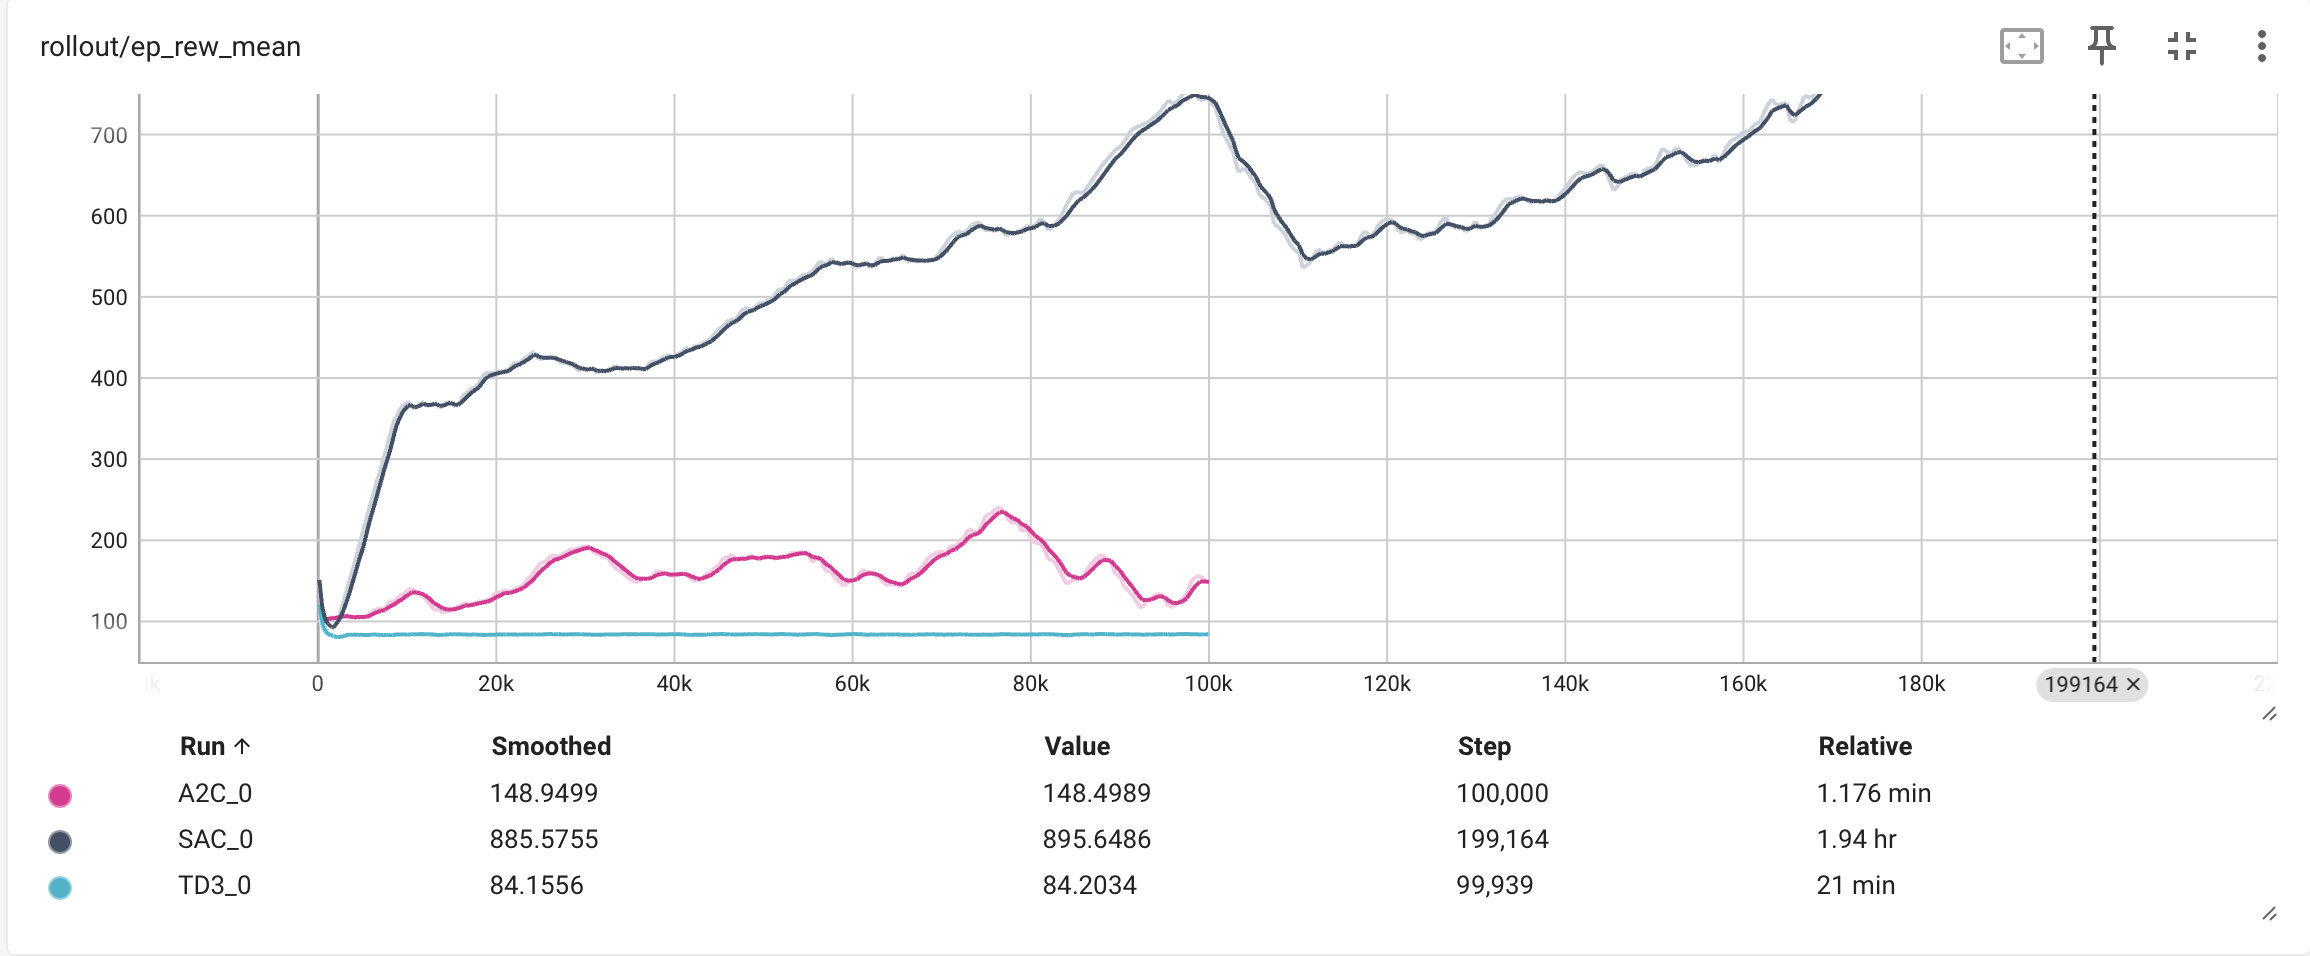
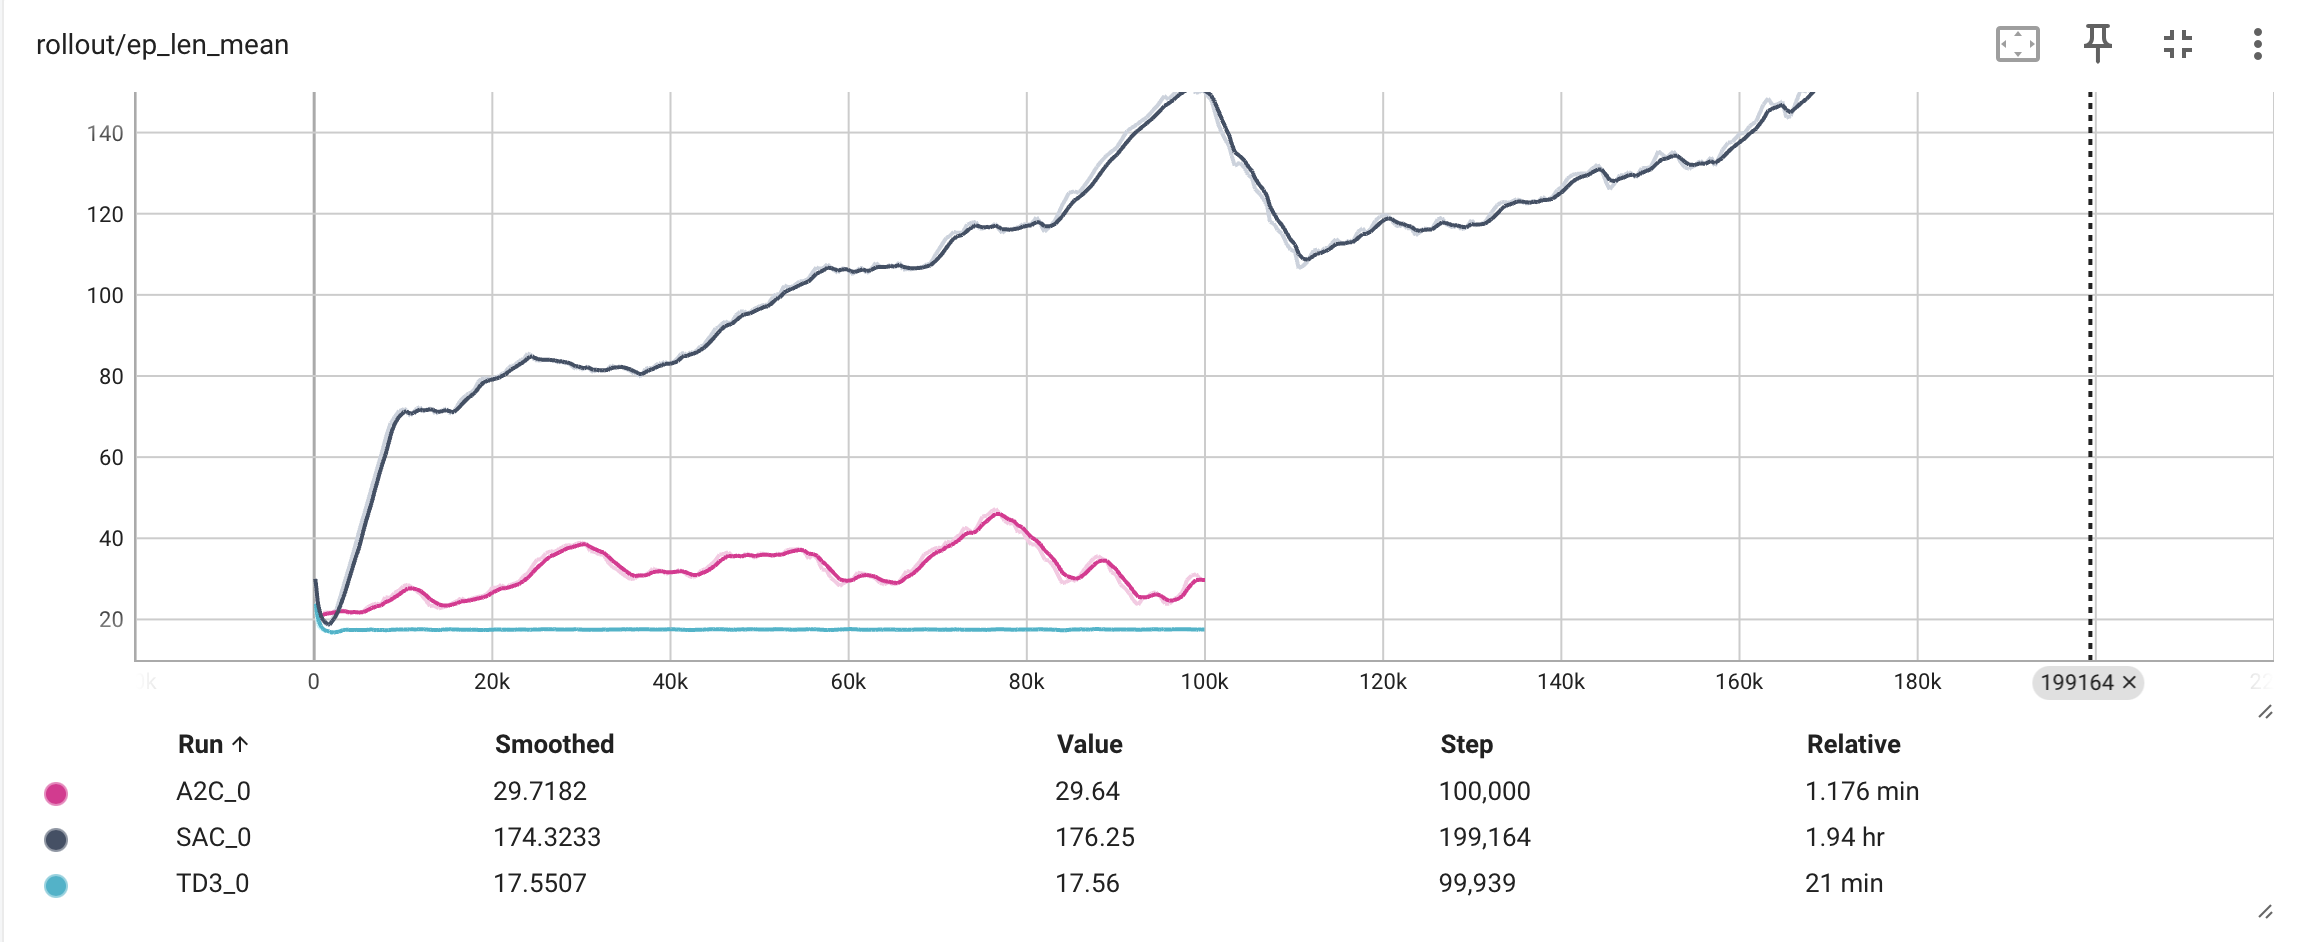
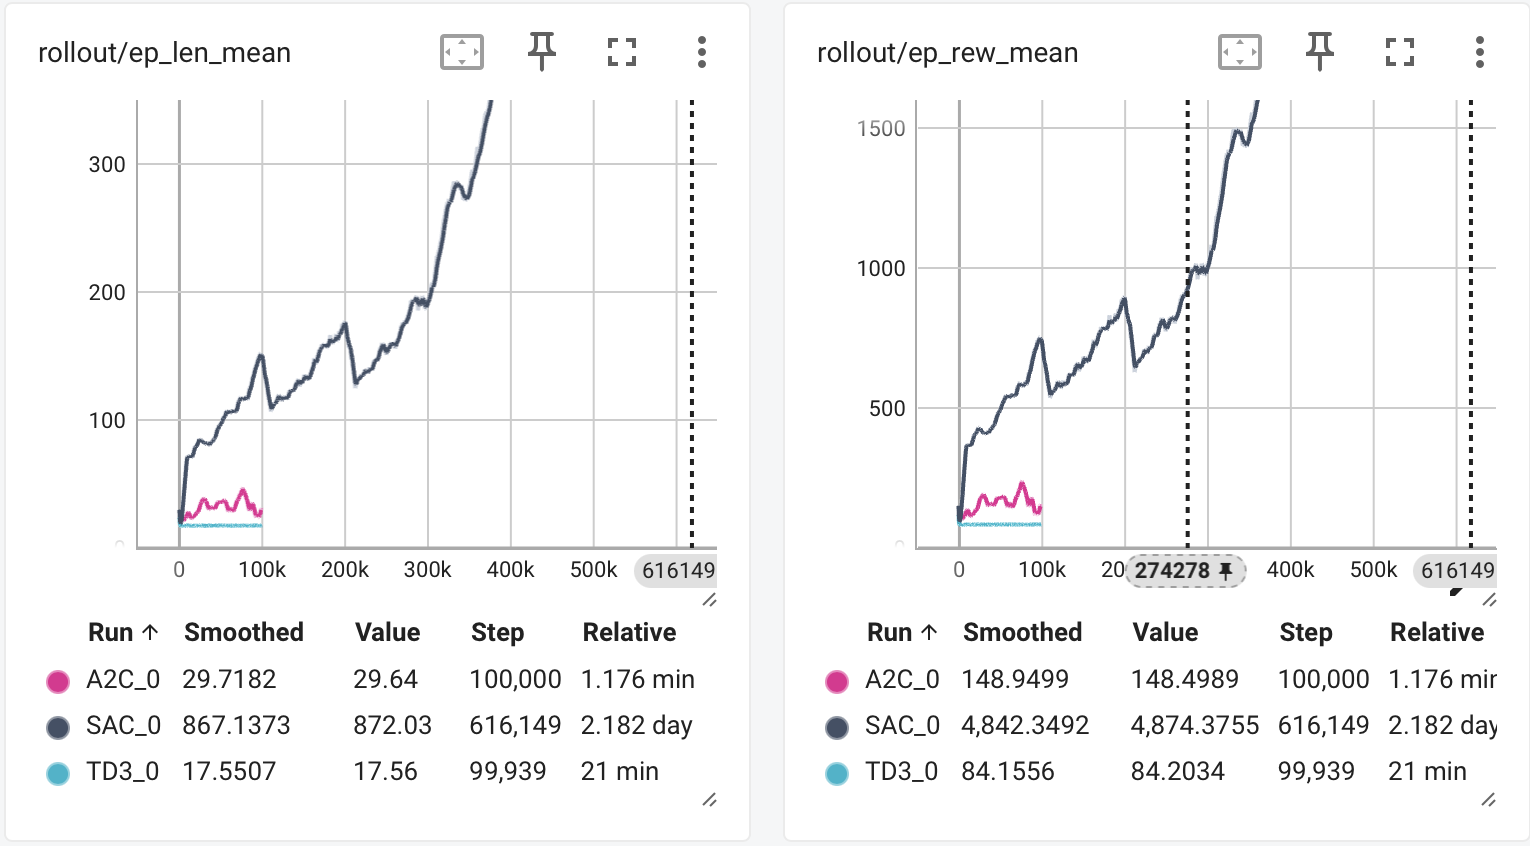

Przeprowadziliśmy równie eksperymenty na rónych wartościach gamma. Jest to liczba z zakresu od 0 do 1, która  pomaga określić, jak silnie przyszłe nagrody wpływają na obecną decyzję agenta. Wartość gamma bliska 0 oznacza, że agent skupia się głównie na natychmiastowych nagrodach, podczas gdy wartość bliska 1 sugeruje, że przyszłe nagrody są niemal równie ważne jak te bieżące.

In [ ]:
def train(env, sb3_algo, max_iters=4, model=None, curr_name=None, gamma=0.99):
    gamma_str = str(gamma).replace('.', '_')
    if model is None:
        match sb3_algo:
            case 'SAC':
                model = SAC('MlpPolicy', env, verbose=1, tensorboard_log=f'{logs_dir}/SAC_gamma{gamma_str}')
            case 'TD3':
                model = TD3('MlpPolicy', env, verbose=1, tensorboard_log=f'{logs_dir}/TD3_gamma{gamma_str}')
            case 'A2C':
                model = A2C('MlpPolicy', env, verbose=1, tensorboard_log=f'{logs_dir}/A2C_gamma{gamma_str}')
            case _:
                print('Invalid algorithm')
                return
        name = f'{models_dir}/{sb3_algo}_gamma{gamma_str}'
    else:
        if curr_name is None:
            print('Please provide a name for the model')
            return
        name = curr_name
        model.set_env(env)

    os.makedirs(name, exist_ok=True)
    TIMESTEPS = 25000
    iters = 0
    while iters < max_iters:
        iters += 1
        model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False)
        model.save(f'{name}/{TIMESTEPS*iters}')

def test(env, sb3_algo, path_to_model):
    match sb3_algo:
        case 'SAC':
            model = SAC.load(path_to_model)
        case 'TD3':
            model = TD3.load(path_to_model)
        case 'A2C':
            model = A2C.load(path_to_model)
        case _:
            print('Invalid algorithm')
            return

    obs = env.reset()[0]
    done = False
    extra_steps = 500
    while True:
        action, _states = model.predict(obs)
        obs, _, done, _, _ = env.step(action)
        
        if done:
            extra_steps -= 1

        if extra_steps < 0:
            break

In [ ]:
gymenv = gym.make('Humanoid-v4', render_mode=None)
train(gymenv, 'SAC', gamma=0.99)
train(gymenv, 'SAC', gamma=0.9)
train(gymenv, 'SAC', gamma=0.8)
train(gymenv, 'SAC', gamma=0.5)
train(gymenv, 'SAC', gamma=0.1)

Wykresy z przebiegu doświadczenia na przestrzeni 100000 epizodów.

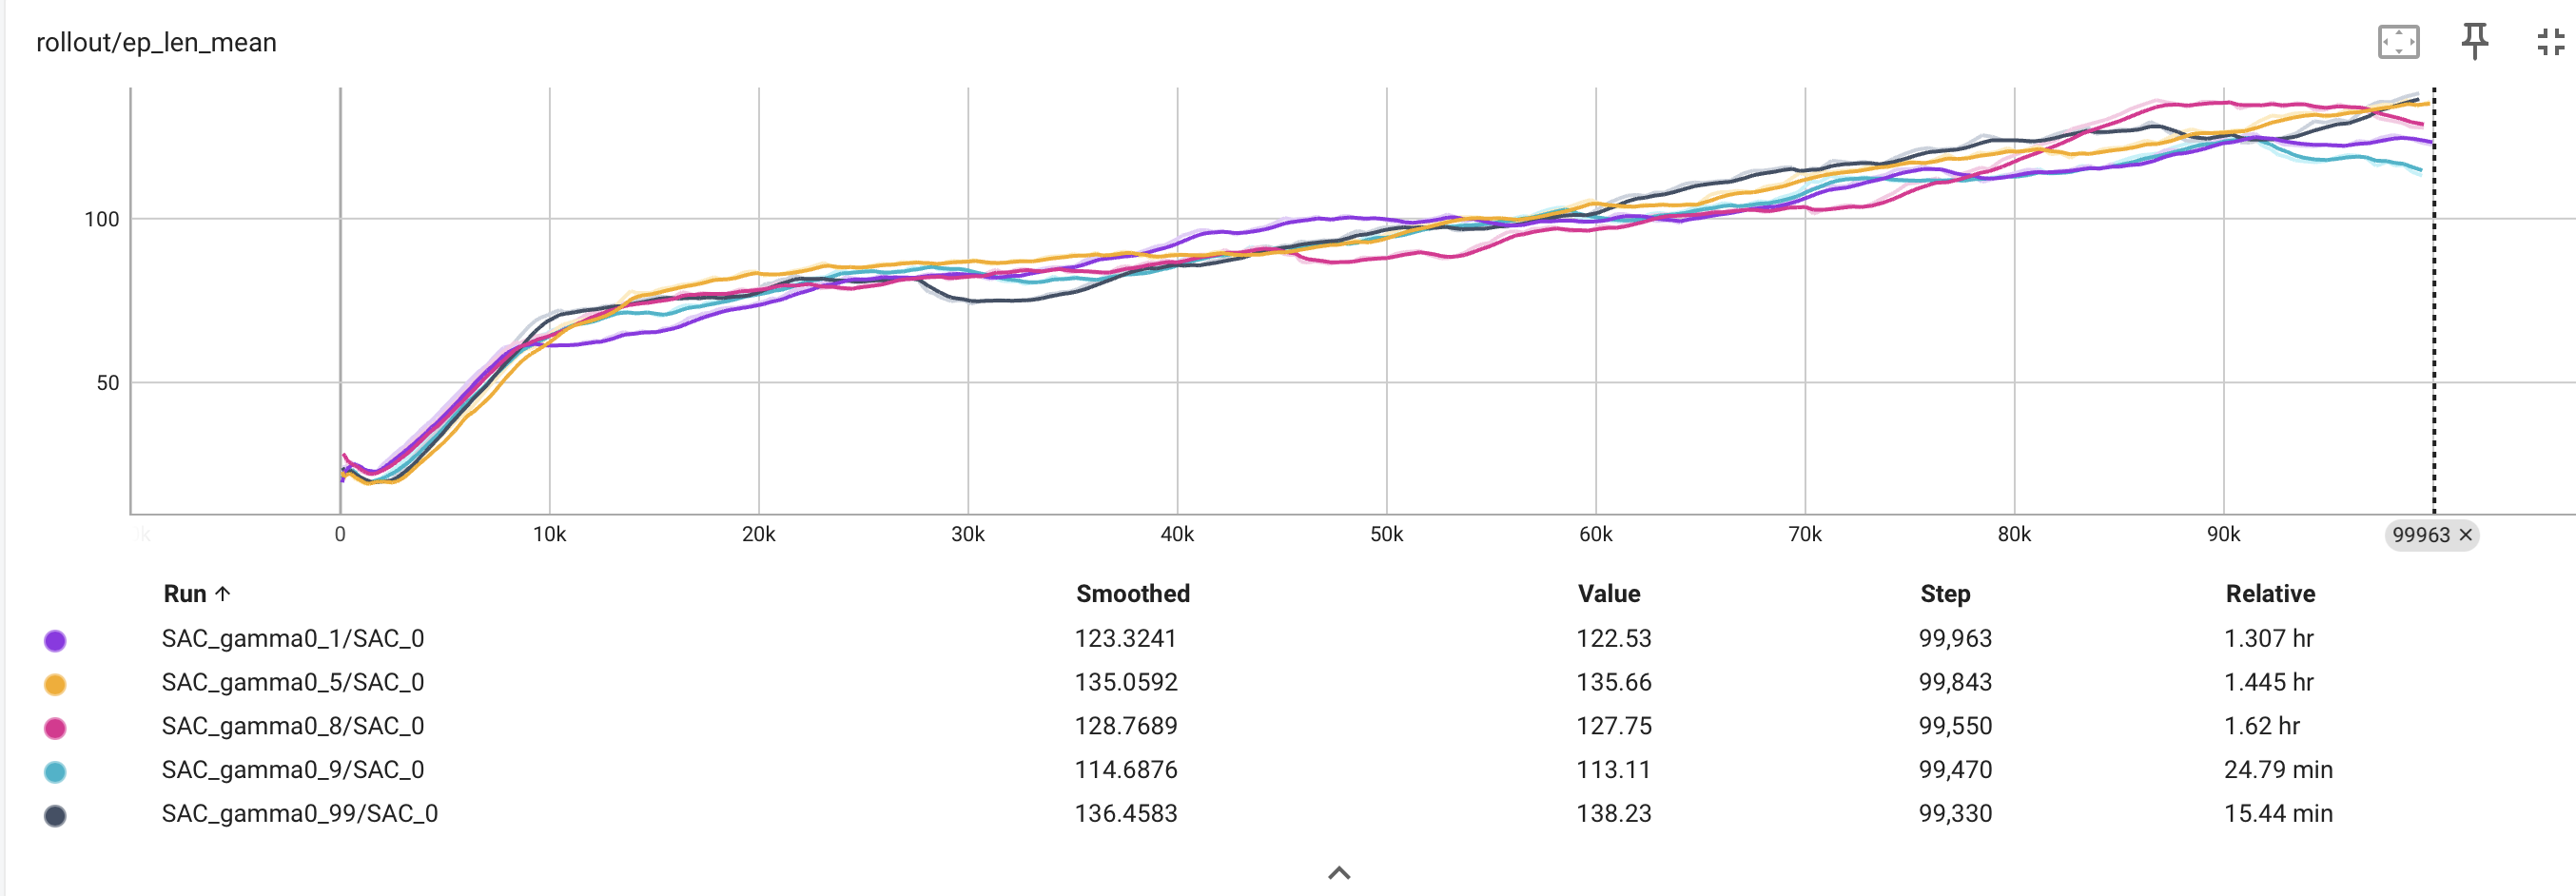
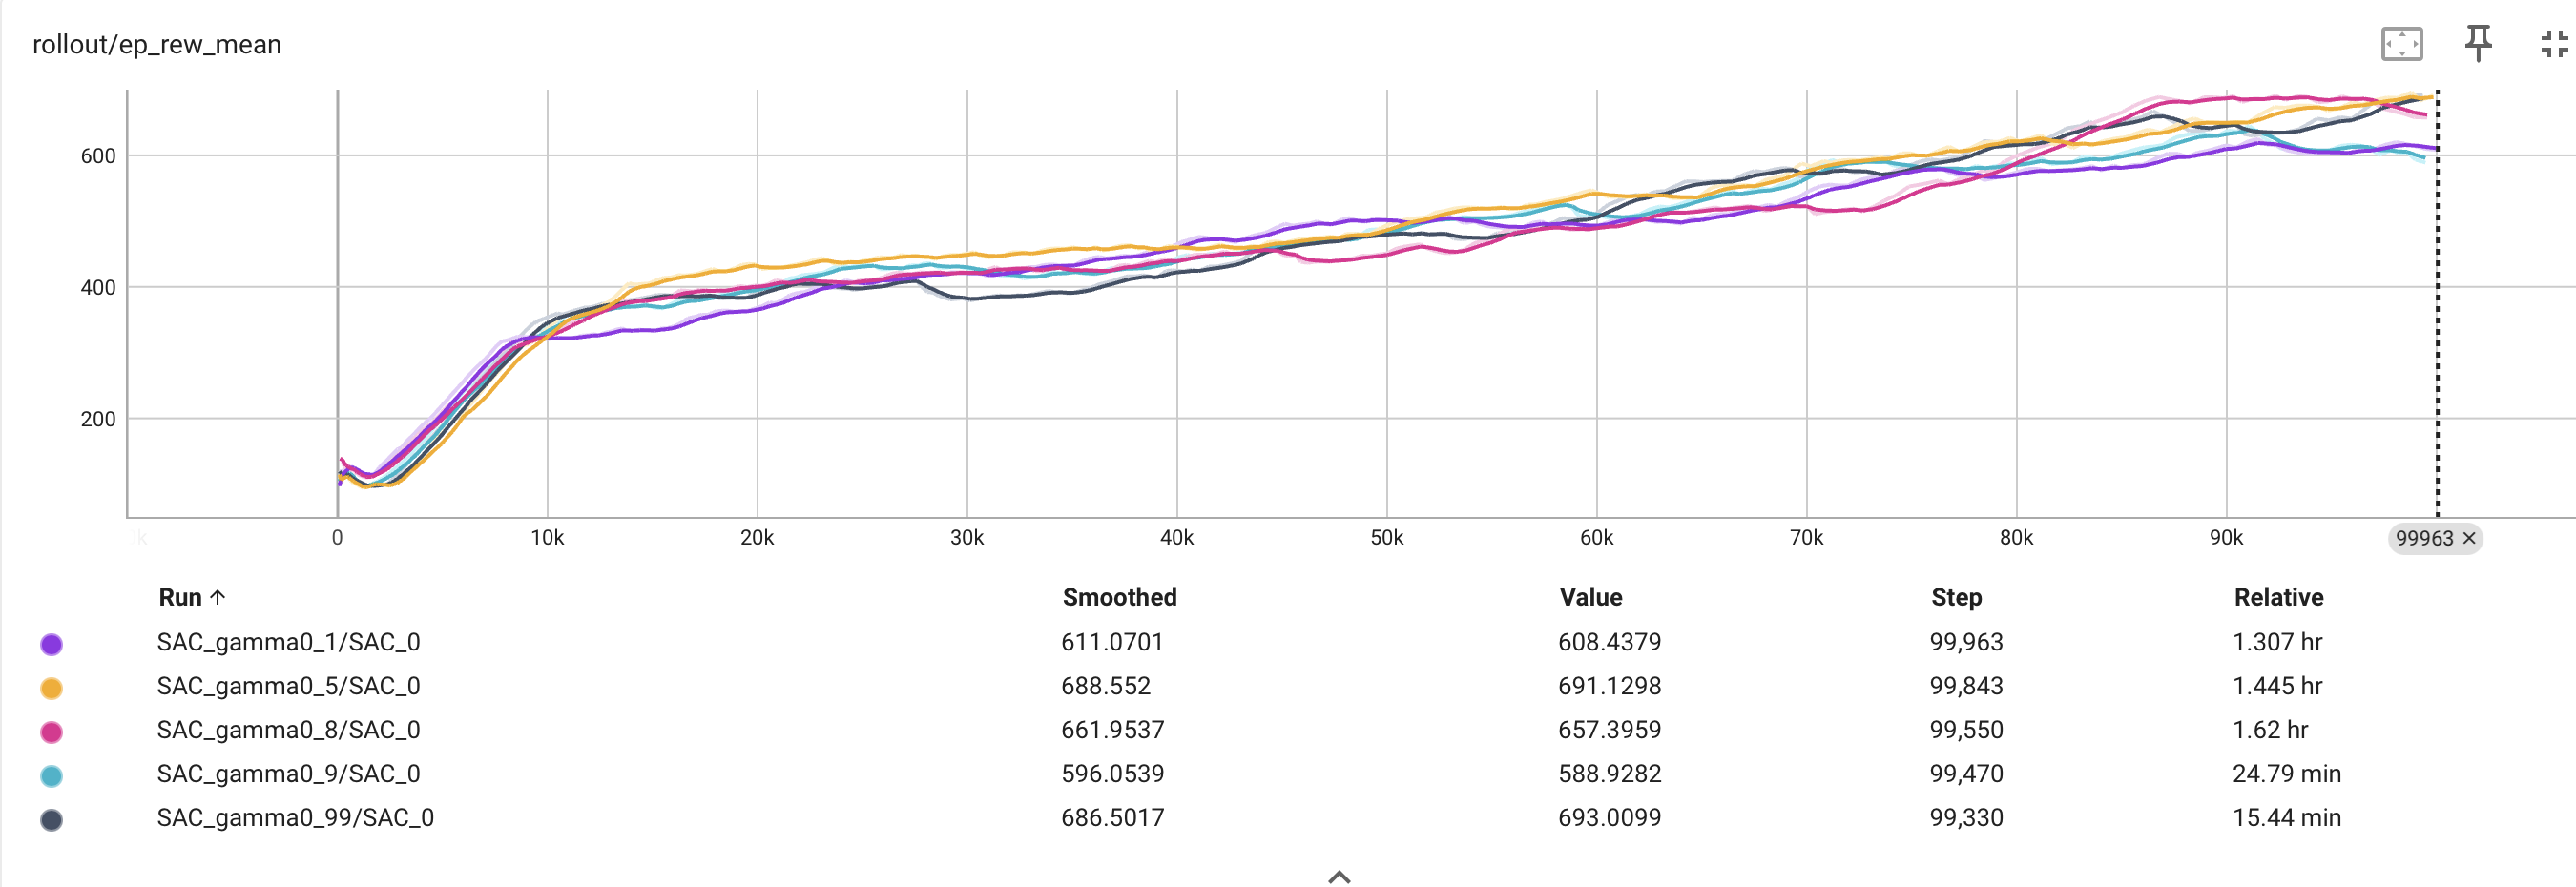

Pierwszy wykres pokazuje średnią długość epizodu w czasie, a drugi średnią nagrodę za epizod. Róne wartości gamma prowadzą do róznych końcowych wyników co wskazuje, że wartość gamma ma wpływ na efektywność uczenia agenta. 